In [129]:
import cv2
from sklearn.cluster import KMeans
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import pandas as pd
import os
from math import floor,sqrt,ceil,log2
from moviepy.editor import VideoFileClip
import librosa
from sklearn.preprocessing import StandardScaler, LabelEncoder
import h5py
from sklearn.metrics import precision_score, recall_score, f1_score
import objectDetection as od
from tabulate import tabulate
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import TfidfVectorizer



## Video Summarization

### Preprocessing and Feature Extraction


#### a. Video Processing and Frame Extraction


In [130]:
def extract_frames(video_path, frame_rate=1):
    video = cv2.VideoCapture(video_path)
    count = 0
    success = True
    frames = []
    
    while success:
        success, image = video.read()
        if count % frame_rate == 0 and success:
            frames.append(image)
        count += 1

    video.release()
    return frames

#### b. Audio Extraction


In [131]:

def extract_audio_from_video(video_path, output_audio_path):
    video = VideoFileClip(video_path)
    audio = video.audio
    audio.write_audiofile(output_audio_path)
    video.close()

#### c.Audio Features

In [132]:
def extract_audio_features_for_each_frame(audio_path, frame_rate,num_frames):
    y, sr = librosa.load(audio_path)

    # Calculate the number of audio samples per video frame
    samples_per_frame = sr / frame_rate

    # Initialize an array to store MFCCs for each frame
    mfccs_per_frame = []

    # Iterate over each frame and extract corresponding MFCCs
    for frame in range(int(len(y) / samples_per_frame)):
        start_sample = int(frame * samples_per_frame)
        end_sample = int((frame + 1) * samples_per_frame)

        # Ensure the end sample does not exceed the audio length
        end_sample = min(end_sample, len(y))

        # Extract MFCCs for the current frame's audio segment
        mfccs_current_frame = librosa.feature.mfcc(y=y[start_sample:end_sample], sr=sr, n_mfcc=13)
        mfccs_processed = np.mean(mfccs_current_frame.T, axis=0)
        mfccs_per_frame.append(mfccs_processed)
    print(np.array(mfccs_per_frame).shape)

    if(len(mfccs_per_frame)>num_frames):
        return mfccs_per_frame[:num_frames]
    return mfccs_per_frame


#### d. Feature Extraction (example with visual features using a CNN)


In [133]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
import cv2
import h5py

model = VGG16(weights='imagenet', include_top=False)

# Load the weights from the downloaded file
# weights_path = 'vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5' # Replace with the actual path
# base_model.load_weights(weights_path)

# # Create a new Sequential model and add the VGG16 base model
# model = Sequential()
# model.add(base_model)

def extract_visual_features(frames):
    features = []
    for frame in frames:
        if frame is not None:
            img = cv2.resize(frame, (224, 224))  # Resize frame to 224x224
            img = img_to_array(img)              # Convert to array
            img = np.expand_dims(img, axis=0)    # Add batch dimension
            img = preprocess_input(img)          # Preprocess for VGG16
            
            feature = model.predict(img,use_multiprocessing=True,workers=4)
            features.append(feature.flatten())

    return features

### Connect Audio/Annotation/Video

#### Annotation To List

In [134]:
def annotation2List(annotation_features):
    # Make the string '1,1,1,3,2,2,4,4,1' to float list
    annotation_float_array=[]
    for annotation in annotation_features:
        
        if isinstance(annotation,str):
            annotation = annotation.split(',')
        if isinstance(annotation,list):
            for anno in annotation:
                annotation_float_array.append(float(anno))
        else:
            annotation_float_array.append(float(annotation))
    return annotation_float_array

#### Title Tokenized

In [135]:
def tfTitle(info_file,video_path):
    info_df = pd.read_csv(info_file, sep='\t')
    info_video=info_df[info_df['video_id']==video_path.split('/')[-1].split('.')[0]]
    title=info_video['title'].values[0]
    # Preprocess titles and extract features (TF-IDF or word embeddings)
    # For TF-IDF:
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    title_features = tfidf_vectorizer.fit_transform([title]).toarray()
    return title_features

#### Extract Data

In [136]:
def extractData(video_path, anno_file, info_file):
    # Extract frames from the video
    frames = extract_frames(video_path)

    # # Extract visual features
    visual_features = extract_visual_features(frames) 

    # Extract audio
    audio_output_path = 'datasets/extractedAudio/extracted_audio.wav'
    extract_audio_from_video(video_path, audio_output_path) 

    # Extract audio features
    audio_features = extract_audio_features_for_each_frame(audio_output_path,30,len(frames))
    
    # Load titles from info file
    title_features = tfTitle(info_file,video_path)
    print(title_features.shape)
    print(title_features)
 
    return visual_features, frames,audio_features, title_features


### Kmeans and feature connection

##### One Hot Encoding

In [137]:
def one_hot_encode(objects_in_frame, unique_objects):
    # Handle None or empty values as 'no_object'
    object_array = ['no_object' if x is None or len(x) == 0 else x for x in objects_in_frame]

    # Reshape the array for OneHotEncoder
    object_array = np.array(object_array).reshape(-1, 1)

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse=False,dtype=float, categories=[unique_objects])

    # Fit and transform the data
    one_hot_encoded = encoder.fit_transform(object_array)
    return one_hot_encoded

##### Detect objects and return padded encoded

In [138]:
def detectObjects(frames, yolo_model, classes, objects=None):
    if objects is None:
        print('Detecting objects in frames...')
        objects = od.detect_objects_in_all_frames(frames, yolo_model, classes)
    
    # Handle cases with multiple objects per frame
    # Here, taking the first detected object as an example
    objects = [frame_objects[0] if frame_objects else None for frame_objects in objects]

    # Generate unique objects and include 'no_object'
    unique_objects = sorted(set(objects + ['no_object']))

    # One-hot encoding of objects
    encoded_objects = one_hot_encode(objects, unique_objects)

    # Padding not required as one-hot encoding ensures consistent vector length
    
    return encoded_objects, objects

##### plot Data $Remove it later

In [139]:
def plotData(combined_features_normalized, kmeans):

    plt.figure(figsize=(20, 12))
    plt.scatter(combined_features_normalized[:, 0], combined_features_normalized[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', s=5)  # Reduced size

    # Add labels to each point
    for i, label in enumerate(kmeans.labels_):
        plt.text(combined_features_normalized[i, 0], combined_features_normalized[i, 1], str(label), fontsize=8)  # Reduced fontsize

    plt.title('KMeans Clustering')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

##### Save Data if ness

In [140]:
import pickle
def saveData(name,feature):
    with open(f'pkl/{name}.pkl', 'wb') as f:
        pickle.dump(feature,f)

##### Load Data if ness

In [141]:
import pickle
def getData(feature):
    if os.path.exists(f'pkl/{feature}.pkl'):
        with open(f'pkl/{feature}.pkl', 'rb') as f:
            feature = pickle.load(f)
        return feature
    else:
        return None

### Kmeans

In [142]:
def MultiModalKMeans(video_path, anno_file, info_file,n_components=None):
    """
    Integrate visual, audio, and annotation features from a video,
    and perform clustering on the combined features.

    :param video_path: Path to the video file.
    :param anno_file: Path to the annotation file.
    :param info_file: Path to the info file.
    :param num_clusters: Number of clusters to use in KMeans.
    :return: Cluster labels for each data point.
    """
    
    # Extract data from video
    getDatabool=False
    objects=None
    
    if not getDatabool:
        # Extract data from video and save it
        visual_features,frames,audio_features,title_features=extractData(video_path, anno_file, info_file)
        # saveData('frames',frames)
        # saveData('visual',visual_features)
        # saveData('audio',audio_features)
        # saveData('title',title_features)
    else:
        # Reatrived data from saved files
        frames=getData('frames')
        visual_features=getData('visual')
        audio_features=getData('audio')
        objects=getData('objects')
        title_features=getData('title')
            
    # Combine features with padding
    combined_features = []

    if(objects is None):
        padded_encoded_objects,objects = detectObjects(frames,len(visual_features),len(audio_features))
        # saveData('objects',objects)
    else:
        padded_encoded_objects,objects = detectObjects(frames,len(visual_features),len(audio_features),objects)
    
        
    for i, frame in enumerate(frames):
        # annotation_float_array = annotation2List(annotation_features[i])
        combined_feature = np.concatenate([
            np.array(visual_features[i], dtype=float),
            np.array(audio_features[i], dtype=float),
            padded_encoded_objects[i],
            np.array(title_features, dtype=float).reshape(-1),
        ])
        combined_features.append(combined_feature)

    # Convert to 2D NumPy array and normalize    
    combined_features_normalized = StandardScaler().fit_transform(np.array(combined_features))
    
    # PCA
    if n_components is not None:
        pca = PCA(n_components=n_components,)
        combined_features_reduced = pca.fit_transform(combined_features_normalized)
    else:
        combined_features_reduced = combined_features_normalized
    
    num_clusters= ceil(sqrt(sqrt(len(combined_features_reduced) * 2)))
    
    print("Number of clusters:", num_clusters)
    
    # Perform clustering
    print("Performing clustering...")
    try:
        if num_clusters:
            kmeans = KMeans(n_clusters=num_clusters) 
            kmeans.fit(combined_features_reduced)
            plotData(combined_features_reduced,kmeans) #Delete later
            
            return [frames, kmeans.labels_,objects]
    except:
        print('Error None number of clusters')
    # return the frames and the labels


### Summarization

#### Find min cluster

In [143]:
from collections import Counter
def getMinClusster(labels):
    cluster_counts = Counter(labels)

    # Find the cluster with the maximum number of frames
    return min(cluster_counts, key=cluster_counts.get),cluster_counts 

#### Frames Selection

In [144]:
def frame_selection(frames, labels):
    """
    Create a summary by selecting frames from the most populous cluster.

    :param frames: List of frames.
    :param labels: Cluster labels for each frame.
    :return: List of frames belonging to the most populous cluster.
    """
    # Count the number of frames in each cluster
    max_cluster,cluster_counts = getMinClusster(labels)

    # Initialize lists for indices and frames
    summary_indices = []  # to measure the importance based on annotation
    summary_frames = []

    # Iterate and select frames and their indices belonging to the most populous cluster
    for index, (frame, label) in enumerate(zip(frames, labels)):
        if label == max_cluster:
            summary_indices.append(index)
            summary_frames.append(frame)

    print(f"Number of frames selected for summary: {len(summary_frames)}, Cluster: {max_cluster}")
    # print all clusters len
    print(f"Cluster counts: {cluster_counts}")
    return summary_frames,summary_indices

def frameSelectionForEachCluster(frames):
    """
    Create a summary by selecting frames from the most populous cluster.

    :param frames: List of frames.
    :param labels: Cluster labels for each frame.
    :return: List of frames belonging to the most populous cluster.
    """
    # Initialize lists for indices and frames
    summary_indices = []  # to measure the importance based on annotation
    summary_frames = []

    # Iterate and select frames and their indices belonging to the most populous cluster
    for index, (frame) in enumerate(frames):
        summary_indices.append(index)
        summary_frames.append(frame)

    print(f"Number of frames selected for summary: {len(summary_frames)}")
    # print all clusters len
    # print(f"Cluster counts: {cluster_counts}")
    return summary_frames,summary_indices

#### Video Creator

In [145]:
def create_video_from_frames(frames, output_path, frame_rate=30):
    if not frames:
        print("No frames to create a video.")
        return None
    # Determine the width and height from the first frame
    height, width, layers = frames[0].shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, frame_rate, (width, height))

    # Write each frame to the video
    for frame in frames:
        out.write(frame)

    # Release the VideoWriter object
    out.release()
    return output_path

#### Load .Mat file

In [146]:
def decode_titles(encoded_titles, hdf5_file):
    decoded_titles = []
    for ref_array in encoded_titles:
        # Handle the case where each ref_array might contain multiple references
        for ref in ref_array:
            # Dereference each HDF5 object reference to get the actual data
            title_data = hdf5_file[ref]
            # Decode the title
            decoded_title = ''.join(chr(char[0]) for char in title_data)
            decoded_titles.append(decoded_title)
    return decoded_titles


def load_mat_file(file_path,videoID):
    """
    Load a .mat file and return its contents.

    :param file_path: Path to the .mat file.
    :return: Contents of the .mat file.
    """
    with h5py.File(file_path, 'r') as file:
        user_anno_refs=file['tvsum50']['user_anno'][:] # type: ignore
        video_refs=file['tvsum50']['video'][:] # type: ignore

        decoded_videos = decode_titles(video_refs,file)
    
        annotations = []        
        # Get the index from decoded video list to find the annotation for the video
        index = [i for i, x in enumerate(decoded_videos) if x.lower() in videoID.lower()][0]
        
        # Iterate over each reference
        for ref in user_anno_refs: # type: ignore
            # Dereference each HDF5 object reference
            ref_data = file[ref[0]]

            # Convert to NumPy array and add to the annotations list
            annotations.append(np.array(ref_data))
            
        return annotations[index]

#### f1score with ground_truth

In [147]:
def evaluate_frame_selection(ground_truth, summary_indices):
    """
    Evaluate the selected frames by comparing them with the ground truth.
    
    Args:
    ground_truth: Ground truth annotations.
    summary_indices: Indices of the selected frames.
    
    Returns:
    Average importance score, max importance score, and proportion of frames with high importance score.
    """
    
    # Evaluate the selected frames
    selected_importance_scores = ground_truth[summary_indices]
    
    # Calculate metrics
    if selected_importance_scores.size == 0:
        average_importance = 0
        max_importance = 0
        proportion_high_importance = 0
    else:
        average_importance = np.mean(selected_importance_scores)  # Average importance score
        max_importance = np.max(selected_importance_scores)  # Max importance score
        # Calculate the proportion of frames with high importance score
        proportion_high_importance = np.mean(selected_importance_scores >= np.floor(max_importance))
        
    return average_importance, max_importance,proportion_high_importance


In [148]:
def Evaluation(ground_truth_path,summary_indices,videoID):
    
    # Get the ground_truth
    ground_truth = np.array(load_mat_file(ground_truth_path, videoID))
    
    # Find the mean of all annotators
    gold_standard = np.mean(ground_truth, axis=0)
    
    # based on annotators find the avg_importance, max_importance, prop_high_importance
    avg_importance, max_importance, prop_high_importance = evaluate_frame_selection(gold_standard, summary_indices)

    # Thresholding based on max_importance
    threshold=floor(np.mean(avg_importance))
    
    
    # Binary conversion
    binary_ground_truth = np.where(gold_standard >= threshold, 1, 0) 
    
    # Selected frames binary conversion
    selected_frames_binary = np.zeros_like(binary_ground_truth)
    selected_frames_binary[summary_indices] = 1
    
    # Calculate metrics
    precision = precision_score(binary_ground_truth, selected_frames_binary)
    recall = recall_score(binary_ground_truth, selected_frames_binary)  
    f1 = f1_score(binary_ground_truth, selected_frames_binary, average='macro')
    
    # return metrics
    return threshold,precision,recall,f1,avg_importance,max_importance,prop_high_importance


#### KnapSack

In [149]:
def knapsack_for_video_summary(values, weights, capacity, scale_factor=30):
    """
    Apply the 0/1 Knapsack algorithm to select video segments for summarization.

    :param values: List of importance scores for each segment.
    :param weights: List of durations for each segment in seconds.
    :param capacity: Maximum total duration for the summary in seconds.
    :param scale_factor: Factor to scale weights to integers.
    :return: Indices of the segments to include in the summary.
    """
    # Scale weights and capacity
    weights = [int(w * scale_factor) for w in weights]
    capacity = int(capacity * scale_factor)

    n = len(values)
    K = [[0 for _ in range(capacity + 1)] for _ in range(n + 1)]

    # Build table K[][] in a bottom-up manner
    for i in range(n + 1):
        for w in range(capacity + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif weights[i-1] <= w:
                K[i][w] = max(values[i-1] + K[i-1][w-weights[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]

    # Find the selected segments
    res = K[n][capacity]
    w = capacity
    selected_indices = []

    for i in range(n, 0, -1):
        if res <= 0:
            break
        if res == K[i-1][w]:
            continue
        else:
            selected_indices.append(i-1)
            res = res - values[i-1]
            w = w - weights[i-1]

    selected_indices.reverse()
    return selected_indices


#### importance score

In [150]:
def calculate_importance_scores(labels, detected_objects):
    """Here the importance for all the labels together..

    """
    # Count the frequency of each label
    label_counts = Counter(labels)

    # Assign a basic importance score based on the inverse frequency of cluster labels
    base_importance_scores = [1 / label_counts[label] for label in labels]

    # Additional importance based on detected objects
    object_importance_scores = []
    for objects in detected_objects:
        if objects:  # if the list is not empty
            # Add extra importance for each detected object
            object_importance_scores.append(len(objects))
        else:
            object_importance_scores.append(0)

    # Combine base importance scores with object importance scores
    max_object_score = max(object_importance_scores) if object_importance_scores else 1
    
    # Normalize object importance scores for simplicity
    normalized_object_scores = [score / max_object_score for score in object_importance_scores]

    # Final importance score is a combination of base and object scores
    importance_scores = [base + obj for base, obj in zip(base_importance_scores, normalized_object_scores)]
    
    print("Average importance score:", np.mean(importance_scores))
    
    return importance_scores

In [151]:
def calculate_importance_scores_for_cluster(cluster_frames, detected_objects_per_frame):

    # Initialize importance scores for the cluster
    importance_scores = []

    # Calculate object-based importance for each frame in the cluster
    for frame_index in cluster_frames:
        # Calculate object importance
        objects = detected_objects_per_frame[frame_index]
        object_importance = len(objects) if objects else 0

        # Add object importance to the list
        importance_scores.append(object_importance)

    # Normalize the importance scores
    max_importance = max(importance_scores, default=1)
    if max_importance == 0:
        max_importance = 1  # To prevent division by zero

    normalized_importance_scores = [score / max_importance for score in importance_scores]

    return normalized_importance_scores


#### Map labels with frames

In [152]:
def map_frames_to_labels_with_indices(frames, labels):
    label_frame_dict = {}
    for label, (frame_index, frame) in zip(labels, enumerate(frames)):
        if label not in label_frame_dict:
            label_frame_dict[label] = []
        label_frame_dict[label].append((frame_index, frame))
    return label_frame_dict

# Code to create summary video

#### Variables

In [153]:
annotation_path='datasets/ydata-tvsum50-v1_1/data/ydata-tvsum50-anno.tsv'
info_path='datasets/ydata-tvsum50-v1_1/data/ydata-tvsum50-info.tsv'

In [154]:
video_path='datasets/ydata-tvsum50-v1_1/video/'
summary_video_path='datasets/summary_videos/'

In [155]:
ground_truth_path='datasets/ydata-tvsum50-v1_1/ground_truth/ydata-tvsum50.mat'

##### Get the list of the videos in the folder

In [156]:
video_list = [video for video in os.listdir(video_path) if video.endswith('.mp4')]  # List comprehension

##### Yolo Model

In [157]:
import torch
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True,)

with open("yolo/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

Using cache found in C:\Users\vasil/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-11-30 Python-3.11.3 torch-2.1.1+cpu CPU

Fusing layers... 


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [158]:
frame_rate = 30  # or whatever your frame rate is
frame_duration = 1 / frame_rate  # Duration of each frame in seconds
capacity = 15  # 15 seconds summary

#### Function for videoSummarizion

In [159]:
def videoSumm(annotation_path=None, info_path=None, video_path=None, summary_video_path=None,video_list=None):
    for video in video_list: 
        # if(video=='-esJrBWj2d8.mp4'):
        #     continue
        video='-esJrBWj2d8.mp4'
        # Kmeans clustering
        frames,labels,objects = MultiModalKMeans(video_path+video, annotation_path, info_path,n_components=2)

        """ USE THIS IN CASE OF CREATING VIDEO FOR EACH CLUSTER"""
        cluster_dict = map_frames_to_labels_with_indices(frames, labels)
        
        # keep track of scores
        scores = []
        model_videos=[]
        for index, cluster in cluster_dict.items():
            print("Calculate Cluster:", index)
            # Extract just the frame indices for importance score calculation
            cluster_frame_indices = [frame_index for frame_index, _ in cluster]

            # Calculate importance scores for this cluster
            importance = calculate_importance_scores_for_cluster(cluster_frame_indices, objects)

            # Create a list of durations, one for each frame in the cluster
            durations = [frame_duration] * len(importance)

            # Apply the knapsack algorithm
            summary_indices = knapsack_for_video_summary(importance, durations, capacity)

            # Select Representative Frames (extracting frame part from each tuple)
            summary_frames = [cluster[i][1] for i in summary_indices]  # [1] extracts the frame from (frame_index, frame)
            
            # Extract original indices for evaluation
            # i want to extract the original indices from the cluster cause the summary_indices are based on the all frames
            # so i need to extract the original indices from each cluster
            original_indices_for_eval = [cluster[i][0] for i in summary_indices]  # [0] extracts the original frame index

            # Evaluate
            evaluated_metrics = Evaluation(ground_truth_path, original_indices_for_eval, video.split('.')[0])
            
            # Append index to metrics
            scores.append((str(index),) + evaluated_metrics)
            
            # Get the model_video based on the index
            model_videos.append([str(index),summary_frames,f"{summary_video_path}{index}-{video}"])
            
        # Sort the table of scores based on F1 score
        scores.sort(key=lambda x: x[4], reverse=True)
        
        index, summary_frames, output_path = next((model_video for model_video in model_videos if model_video[0] == scores[0][0]), (None, None, None))        
        
        print(f"Best model: {index}",output_path)
        
        # fix output_path
        output_path=output_path.replace(f'{index}-','')
        # Create Summary Video
        create_video_from_frames(summary_frames, output_path, 30)
        
        # print results
        print('Video:',video)
        print(tabulate(scores, headers=['videoID','Threshold','Precision', 'Recall', 'F1 Score', 'Avg_importance', 'Max_importance', 'Prop_high_importance'], tablefmt='fancy_grid'))
        
        del model_videos
        del scores
        del summary_frames
        del importance
        del cluster_frame_indices
        
        return

# Code for dynamic annotation and video summarization

Number of clusters: 11
Performing clustering...


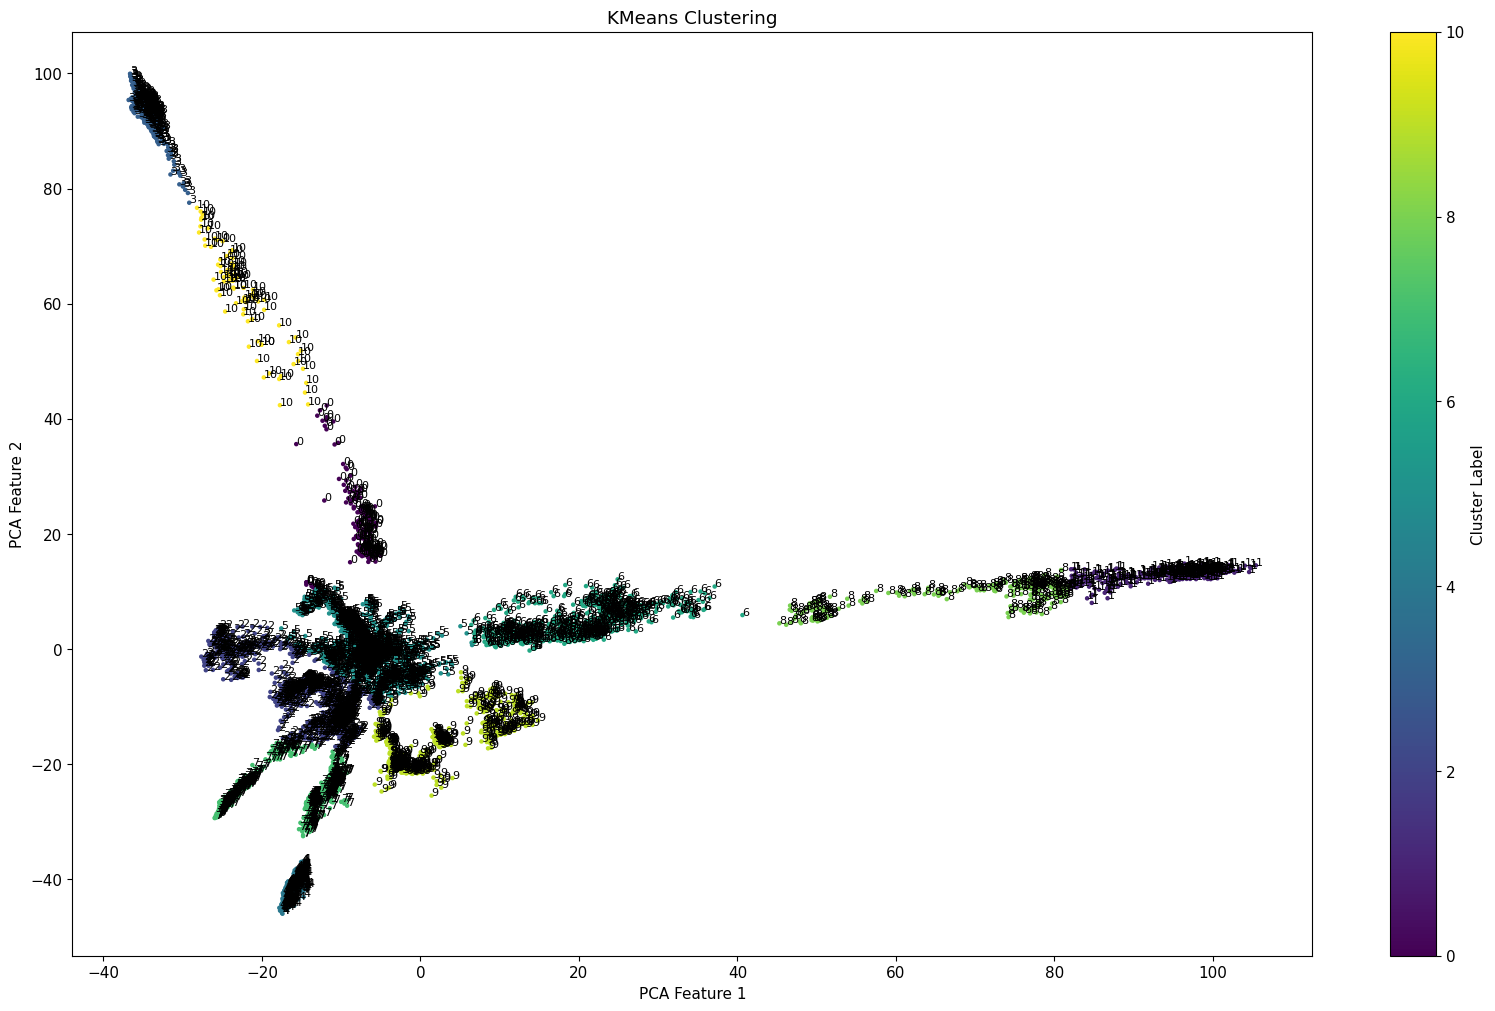

Calculate Cluster: 2
Calculate Cluster: 5
Calculate Cluster: 9
Calculate Cluster: 7
Calculate Cluster: 4
Calculate Cluster: 6
Calculate Cluster: 8
Calculate Cluster: 1
Calculate Cluster: 0
Calculate Cluster: 10
Calculate Cluster: 3
Best model: 4 datasets/summary_videos/4--esJrBWj2d8.mp4
Video: -esJrBWj2d8.mp4
╒═══════════╤═════════════╤═════════════╤═══════════╤════════════╤══════════════════╤══════════════════╤════════════════════════╕
│   videoID │   Threshold │   Precision │    Recall │   F1 Score │   Avg_importance │   Max_importance │   Prop_high_importance │
╞═══════════╪═════════════╪═════════════╪═══════════╪════════════╪══════════════════╪══════════════════╪════════════════════════╡
│         4 │           3 │    0.824176 │ 0.714286  │  0.875598  │          3.06154 │             3.35 │              0.824176  │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         7 │           2 │    1       

In [160]:
videoSumm(annotation_path, info_path, video_path, summary_video_path, video_list)

╒═══════════╤═════════════╤═════════════╤════════════╤════════════╤══════════════════╤══════════════════╤════════════════════════╕
│   videoID │   Threshold │   Precision │     Recall │   F1 Score │   Avg_importance │   Max_importance │   Prop_high_importance │
╞═══════════╪═════════════╪═════════════╪════════════╪════════════╪══════════════════╪══════════════════╪════════════════════════╡
│         2 │           3 │    0.824176 │ 0.714286   │ 0.875598   │          3.06154 │             3.35 │              0.824176  │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         6 │           2 │    1        │ 0.132075   │ 0.48169    │          2.12333 │             2.4  │              1         │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│        10 │           2 │    1        │ 0.0578616  │ 0.411485   │          2.2462  │             2.45 │              1         │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         5 │           1 │    1        │ 0.0651042  │ 0.0611247  │          1.82956 │             2.4  │              0.277778  │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         1 │           1 │    1        │ 0.0651042  │ 0.0611247  │          1.5     │             2.05 │              0.151111  │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         8 │           1 │    1        │ 0.0651042  │ 0.0611247  │          1.92178 │             2.45 │              0.211111  │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         3 │           1 │    1        │ 0.0651042  │ 0.0611247  │          1.66778 │             2.05 │              0.248889  │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         9 │           1 │    1        │ 0.0651042  │ 0.0611247  │          1.461   │             2.15 │              0.0111111 │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         4 │           1 │    1        │ 0.0347222  │ 0.033557   │          1.94958 │             2.55 │              0.441667  │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         7 │           1 │    1        │ 0.0313947  │ 0.0304391  │          1.52258 │             1.65 │              1         │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         0 │           1 │    1        │ 0.00202546 │ 0.00202137 │          1.45    │             1.45 │              1         │
╘═══════════╧═════════════╧═════════════╧════════════╧════════════╧══════════════════╧══════════════════╧════════════════════════╛

╒═══════════╤═════════════╤═════════════╤═══════════╤════════════╤══════════════════╤══════════════════╤════════════════════════╕
│   videoID │   Threshold │   Precision │    Recall │   F1 Score │   Avg_importance │   Max_importance │   Prop_high_importance │
╞═══════════╪═════════════╪═════════════╪═══════════╪════════════╪══════════════════╪══════════════════╪════════════════════════╡
│         7 │           3 │    0.824176 │ 0.714286  │  0.875598  │          3.06154 │             3.35 │               0.824176 │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         0 │           2 │    0.884444 │ 0.125157  │  0.470639  │          2.324   │             2.95 │               0.884444 │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         4 │           2 │    1        │ 0.117925  │  0.468909  │          2.12133 │             2.4  │               1        │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         3 │           2 │    0.586667 │ 0.0830189 │  0.420579  │          2.232   │             3.05 │               0.133333 │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         9 │           2 │    1        │ 0.0141509 │  0.366062  │          2.14    │             2.25 │               1        │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         6 │           1 │    1        │ 0.0651042 │  0.0611247 │          1.91667 │             2.55 │               0.4      │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         2 │           1 │    1        │ 0.0651042 │  0.0611247 │          1.92889 │             2.45 │               0.211111 │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         1 │           1 │    1        │ 0.0651042 │  0.0611247 │          1.63333 │             2    │               0.133333 │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         5 │           1 │    1        │ 0.0474537 │  0.0453039 │          1.95046 │             2.4  │               0.365854 │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         8 │           1 │    1        │ 0.0231481 │  0.0226244 │          1.48125 │             1.5  │               1        │
╘═══════════╧═════════════╧═════════════╧═══════════╧════════════╧══════════════════╧══════════════════╧════════════════════════╛

## Results after the video call

In [161]:
"""
╒═══════════╤═════════════╤═════════════╤════════════╤════════════╤══════════════════╤══════════════════╤════════════════════════╕
│   videoID │   Threshold │   Precision │     Recall │  F1 BINARY │   Avg_importance │   Max_importance │   Prop_high_importance │
╞═══════════╪═════════════╪═════════════╪════════════╪════════════╪══════════════════╪══════════════════╪════════════════════════╡
│         8 │           3 │  0.821229   │ 0.7        │ 0.755784   │          3.06131 │             3.35 │             0.821229   │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         2 │           3 │  0.167939   │ 0.104762   │ 0.129032   │          2.61374 │             3    │             0.167939   │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         4 │           2 │  1          │ 0.0971698  │ 0.177128   │          2.13625 │             2.4  │             1          │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         6 │           2 │  0.437778   │ 0.0619497  │ 0.10854    │          1.92333 │             2.4  │             0.437778   │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         9 │           2 │  1          │ 0.0327044  │ 0.0633374  │          2.6024  │             2.7  │             1          │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         0 │           1 │  1          │ 0.0231481  │ 0.0452489  │          1.48125 │             1.5  │             1          │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         5 │           2 │  0.12       │ 0.0169811  │ 0.0297521  │          1.626   │             2    │             0.12       │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         7 │           1 │  1          │ 0.0157697  │ 0.0310497  │          1.5     │             1.65 │             1          │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│        10 │           2 │  0.192771   │ 0.00503145 │ 0.00980693 │          1.93675 │             2.45 │             0.192771   │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         1 │           2 │  0.00888889 │ 0.00125786 │ 0.00220386 │          1.44733 │             2.15 │             0.00888889 │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         3 │           0 │  0          │ 0          │ 0          │          0       │             0    │             0          │
╘═══════════╧═════════════╧═════════════╧════════════╧════════════╧══════════════════╧══════════════════╧════════════════════════╛

╒═══════════╤═════════════╤═════════════╤═══════════╤═══════════╤══════════════════╤══════════════════╤════════════════════════╕
│   videoID │   Threshold │   Precision │    Recall │ F1 BINARY │   Avg_importance │   Max_importance │   Prop_high_importance │
╞═══════════╪═════════════╪═════════════╪═══════════╪═══════════╪══════════════════╪══════════════════╪════════════════════════╡
│         8 │           3 │    0.821229 │ 0.7       │ 0.755784  │          3.06131 │             3.35 │             0.821229   │
├───────────┼─────────────┼─────────────┼───────────┼───────────┼──────────────────┼──────────────────┼────────────────────────┤
│         4 │           2 │    1        │ 0.0971698 │ 0.177128  │          2.13625 │             2.4  │             1          │
├───────────┼─────────────┼─────────────┼───────────┼───────────┼──────────────────┼──────────────────┼────────────────────────┤
│         2 │           2 │    0.984733 │ 0.0811321 │ 0.149913  │          2.61374 │             3    │             0.167939   │
├───────────┼─────────────┼─────────────┼───────────┼───────────┼──────────────────┼──────────────────┼────────────────────────┤
│         6 │           1 │    1        │ 0.0651042 │ 0.122249  │          1.92333 │             2.4  │             0.437778   │
├───────────┼─────────────┼─────────────┼───────────┼───────────┼──────────────────┼──────────────────┼────────────────────────┤
│         5 │           1 │    1        │ 0.0651042 │ 0.122249  │          1.626   │             2    │             0.12       │
├───────────┼─────────────┼─────────────┼───────────┼───────────┼──────────────────┼──────────────────┼────────────────────────┤
│         1 │           1 │    1        │ 0.0651042 │ 0.122249  │          1.44733 │             2.15 │             0.00888889 │
├───────────┼─────────────┼─────────────┼───────────┼───────────┼──────────────────┼──────────────────┼────────────────────────┤
│         9 │           2 │    1        │ 0.0327044 │ 0.0633374 │          2.6024  │             2.7  │             1          │
├───────────┼─────────────┼─────────────┼───────────┼───────────┼──────────────────┼──────────────────┼────────────────────────┤
│         0 │           1 │    1        │ 0.0231481 │ 0.0452489 │          1.48125 │             1.5  │             1          │
├───────────┼─────────────┼─────────────┼───────────┼───────────┼──────────────────┼──────────────────┼────────────────────────┤
│         7 │           1 │    1        │ 0.0157697 │ 0.0310497 │          1.5     │             1.65 │             1          │
├───────────┼─────────────┼─────────────┼───────────┼───────────┼──────────────────┼──────────────────┼────────────────────────┤
│        10 │           1 │    1        │ 0.0120081 │ 0.0237312 │          1.93675 │             2.45 │             0.192771   │
├───────────┼─────────────┼─────────────┼───────────┼───────────┼──────────────────┼──────────────────┼────────────────────────┤
│         3 │           0 │    0        │ 0         │ 0         │          0       │             0    │             0          │
╘═══════════╧═════════════╧═════════════╧═══════════╧═══════════╧══════════════════╧══════════════════╧════════════════════════╛

╒═══════════╤═════════════╤═════════════╤═══════════╤════════════╤══════════════════╤══════════════════╤════════════════════════╕
│   videoID │   Threshold │   Precision │    Recall │   F1 MACRO │   Avg_importance │   Max_importance │   Prop_high_importance │
╞═══════════╪═════════════╪═════════════╪═══════════╪════════════╪══════════════════╪══════════════════╪════════════════════════╡
│         8 │           3 │    0.821229 │ 0.7       │  0.87061   │          3.06131 │             3.35 │             0.821229   │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         4 │           2 │    1        │ 0.0971698 │  0.449667  │          2.13625 │             2.4  │             1          │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         2 │           2 │    0.984733 │ 0.0811321 │  0.434039  │          2.61374 │             3    │             0.167939   │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         6 │           1 │    1        │ 0.0651042 │  0.0611247 │          1.92333 │             2.4  │             0.437778   │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         5 │           1 │    1        │ 0.0651042 │  0.0611247 │          1.626   │             2    │             0.12       │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         1 │           1 │    1        │ 0.0651042 │  0.0611247 │          1.44733 │             2.15 │             0.00888889 │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         9 │           2 │    1        │ 0.0327044 │  0.385748  │          2.6024  │             2.7  │             1          │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         0 │           1 │    1        │ 0.0231481 │  0.0226244 │          1.48125 │             1.5  │             1          │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         7 │           1 │    1        │ 0.0157697 │  0.0155249 │          1.5     │             1.65 │             1          │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│        10 │           1 │    1        │ 0.0120081 │  0.0118656 │          1.93675 │             2.45 │             0.192771   │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         3 │           0 │    0        │ 0         │  0         │          0       │             0    │             0          │
╘═══════════╧═════════════╧═════════════╧═══════════╧════════════╧══════════════════╧══════════════════╧════════════════════════╛
"""

'\n╒═══════════╤═════════════╤═════════════╤════════════╤════════════╤══════════════════╤══════════════════╤════════════════════════╕\n│   videoID │   Threshold │   Precision │     Recall │  F1 BINARY │   Avg_importance │   Max_importance │   Prop_high_importance │\n╞═══════════╪═════════════╪═════════════╪════════════╪════════════╪══════════════════╪══════════════════╪════════════════════════╡\n│         8 │           3 │  0.821229   │ 0.7        │ 0.755784   │          3.06131 │             3.35 │             0.821229   │\n├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤\n│         2 │           3 │  0.167939   │ 0.104762   │ 0.129032   │          2.61374 │             3    │             0.167939   │\n├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤\n│         4 │           2 │  1          │ 0.0971698  │ 0.177128   │      

Me ta etoima frames,labels,objects,visuals,audio
dog
╒═══════════╤═════════════╤═════════════╤═══════════╤════════════╤══════════════════╤══════════════════╤════════════════════════╕
│   videoID │   Threshold │   Precision │    Recall │   F1 Score │   Avg_importance │   Max_importance │   Prop_high_importance │
╞═══════════╪═════════════╪═════════════╪═══════════╪════════════╪══════════════════╪══════════════════╪════════════════════════╡
│         2 │           2 │    1        │ 0.216411  │  0.507317  │          2.39927 │             2.7  │              1         │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         1 │           2 │    0.792952 │ 0.0811542 │  0.37865   │          2.61388 │             3    │              0.264317  │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         6 │           2 │    1        │ 0.0464382 │  0.351086  │          2.79806 │             2.95 │              1         │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         5 │           2 │    1        │ 0.0302074 │  0.334025  │          2.17164 │             2.7  │              1         │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         0 │           1 │    1        │ 0.0934292 │  0.085446  │          1.57431 │             2.7  │              0.104396  │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         3 │           1 │    1        │ 0.0569815 │  0.0539097 │          1.76059 │             2.5  │              0.0495495 │
├───────────┼─────────────┼─────────────┼───────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         4 │           1 │    1        │ 0.0397844 │  0.0382622 │          1.81742 │             2.05 │              0.387097  │
╘═══════════╧═════════════╧═════════════╧═══════════╧════════════╧══════════════════╧══════════════════╧════════════════════════╛

cat
╒═══════════╤═════════════╤═════════════╤════════════╤════════════╤══════════════════╤══════════════════╤════════════════════════╕
│   videoID │   Threshold │   Precision │     Recall │   F1 Score │   Avg_importance │   Max_importance │   Prop_high_importance │
╞═══════════╪═════════════╪═════════════╪════════════╪════════════╪══════════════════╪══════════════════╪════════════════════════╡
│        10 │           3 │    0.824176 │ 0.714286   │  0.875598  │          3.06154 │             3.35 │             0.824176   │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         1 │           2 │    1        │ 0.142138   │  0.490619  │          2.46726 │             3    │             0.128319   │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         0 │           2 │    1        │ 0.13239    │  0.481971  │          2.12363 │             2.4  │             1          │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         8 │           2 │    0.549889 │ 0.0779874  │  0.414519  │          2.02905 │             3.05 │             0.00221729 │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         4 │           2 │    1        │ 0.0578616  │  0.411485  │          2.2462  │             2.45 │             1          │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         6 │           1 │    1        │ 0.0679977  │  0.0636684 │          1.87564 │             2.25 │             0.12766    │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         7 │           1 │    1        │ 0.0651042  │  0.0611247 │          1.44333 │             1.7  │             1          │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         9 │           1 │    1        │ 0.0597512  │  0.0563823 │          1.87167 │             2.4  │             0.302663   │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         2 │           1 │    1        │ 0.0313947  │  0.0304391 │          1.52258 │             1.65 │             1          │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         3 │           1 │    1        │ 0.0134549  │  0.0132762 │          1.42473 │             1.45 │             1          │
├───────────┼─────────────┼─────────────┼────────────┼────────────┼──────────────────┼──────────────────┼────────────────────────┤
│         5 │           1 │    1        │ 0.00491898 │  0.0048949 │          1.55    │             1.55 │             1          │
╘═══════════╧═════════════╧═════════════╧════════════╧════════════╧══════════════════╧══════════════════╧════════════════════════╛

results= one_hot_encoding or binary encoding == same fscore